In [2]:
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
# read together forecast
tog_forecast = pd.read_csv('data/together_forecast/phase_2_forecast_sampled_1h.csv')
tog_forecast = tog_forecast.set_index('time_step')
tog_forecast 

scenario  building       +0h       +1h       +2h       +3h  \
time_step                                                               
0                 0         0  1.066467  0.926882  0.848033  0.803975   
0                 0         1  0.761605  0.741974  0.697885  0.701595   
0                 0         2  0.334184  0.505538  0.559403  0.592007   
0                 0         3  0.677910  0.711004  0.688662  0.695388   
0                 0         4  0.647769  0.696236  0.668756  0.690560   
...             ...       ...       ...       ...       ...       ...   
8759              0         0  1.072377  0.996440  0.741076  0.704916   
8759              0         1  0.274504  0.114037  0.157076  0.149630   
8759              0         2  1.415552  0.638873  0.443291  0.675169   
8759              0         3  1.127068  0.963681  0.906289  0.737928   
8759              0         4  1.306061  1.042310  1.046243  1.003718   

                +4h       +5h       +6h       +7h  ...      +14h      +15h  \
time_step                                          ...                       
0          0.779103  0.831918  0.679700  0.244482  ... -0.345602  0.446270   
0          0.719255  0.756382  0.633262  0.210218  ... -0.350943  0.439364   
0          0.637254  0.685898  0.604959  0.175989  ... -0.341320  0.447794   
0          0.714822  0.753214  0.631144  0.208682  ... -0.351545  0.438454   
0          0.712519  0.743658  0.562326  0.026640  ... -0.762745  0.210296   
...             ...       ...       ...       ...  ...       ...       ...   
8759       0.797859  0.480414  0.480135  0.093980  ... -0.239815  0.767352   
8759       0.198899  0.199958  0.254449  0.209866  ... -2.108082 -1.813556   
8759       0.605032  0.526384  0.618598  0.529869  ... -0.031484 -0.226172   
8759       0.536923  0.454065  0.776352  1.150055  ... -0.931092 -0.862660   
8759       0.879844  0.771638  0.789928  0.856939  ... -1.261027 -0.644508   

               +16h      +17h      +18h      +19h      +20h      +21h  \
time_step                                                               
0          0.828603  1.255095  1.463593  1.295015  1.324265  1.326300   
0          0.792490  1.234255  1.410791  1.273815  1.292081  1.267913   
0          0.795822  1.206389  1.390845  1.242244  1.262031  1.229344   
0          0.795634  1.233967  1.408790  1.271385  1.288912  1.254868   
0          0.627841  1.167524  1.398019  1.269750  1.286318  1.253179   
...             ...       ...       ...       ...       ...       ...   
8759       0.917156  1.028768  1.936889  2.104730  2.055496  1.763792   
8759      -1.404877 -0.756410  0.249774  0.517454  0.238763  0.214997   
8759       0.701916  1.080994  1.668508  1.741744  1.331499  1.395236   
8759      -0.555779 -0.164675  1.077816  2.056134  1.887524  2.007615   
8759       0.281377  0.826619  1.731289  2.452800  2.214763  1.994870   

               +22h      +23h  
time_step                      
0          1.298128  1.173524  
0          1.206104  1.044787  
0          1.160263  0.833793  
0          1.201907  1.026382  
0          1.199091  0.976711  
...             ...       ...  
8759       1.293810  1.288179  
8759       0.303347  0.287472  
8759       1.743208  1.324660  
8759       1.620452  1.508451  
8759       1.787328  1.484993  

[43800 rows x 26 columns]

In [5]:
def find_overlap(horizon, step):
    overlap = [i for i in range(step,horizon)]
    return overlap

def sMAPC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    s_mapc = 0
    for i in range(1, h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        denominator = abs(y_forecast[i]) + abs(y_forecast_previous[i])
        s_mapc += numerator / denominator
    s_mapc *= (200 / (h - 1))
    return s_mapc

def MAC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    mac = 0
    for i in range(h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        mac += numerator
    mac /= (h)
    return mac


In [6]:
def generate_lists(step, horizon):
    previous_list = np.arange(1, horizon - step)
    current_list = np.arange(horizon - step - 1)
    return previous_list, current_list

def generate_lists_same_line(step, horizon):
    previous_list = np.arange(step+1, horizon)
    current_list = np.arange(horizon - step - 1)
    return previous_list, current_list

In [7]:
phase_num = 3
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 24):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    for b_num in range(1, 5):
        tog_forecast_temp = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
        tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
        tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        #sMAPC_v = np.zeros(len(tog_forecast_temp)-1)
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        for i in range(len(tog_forecast_temp)-1):
            step_shift = i % step_forecast
            #print(step_shift)
            prev_indices, current_indices = generate_lists(step_shift,24)
            #print(prev_indices, current_indices)
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            #sMAPC_v[i] = sMAPC(tog_forecast_current, tog_forecast_previous)
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        #print(f'sMAPC{sMAPC_v.mean()}')
        print(f'MAC{MAC_v.mean()}')
        #sMAPC_steps[step_forecast][b_num] = sMAPC_v.mean()
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    # sMAPC_steps_dict[step] equals to average of sMAPC over all buildings
    #sMAPC_steps_dict[step_forecast] = np.mean(list(sMAPC_steps[step_forecast].values()))
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

MAC0.07574556806743002
MAC0.04979611465148138
MAC0.07392653737279292
MAC0.06667064052948239
MAC0.04906553308225197
MAC0.028989195557145683
MAC0.04373607364017053
MAC0.04096101963125611
MAC0.038475552384378366
MAC0.02120132353905166
MAC0.0315893501670658
MAC0.03169414685547844
MAC0.030308663020775437
MAC0.017189107353085806
MAC0.025616565606161493
MAC0.024538901153991582
MAC0.028044731787460114
MAC0.014318853114449498
MAC0.020992301698163823
MAC0.021038838386747027
MAC0.02669041782407104
MAC0.012439788062317091
MAC0.01867130121790013
MAC0.01930295113873198
MAC0.02277960551153446
MAC0.011178554503044301
MAC0.016607011867747063
MAC0.016685294671881578
MAC0.016897905938172964
MAC0.01010920157032884
MAC0.015439194607392638
MAC0.0138677415842637
MAC0.019376629513791533
MAC0.009370339646659013
MAC0.013502379921703228
MAC0.014359777690886113
MAC0.017606764179175546
MAC0.008621868823432162
MAC0.01261796156607869
MAC0.012715692683795764
MAC0.016496433082243356
MAC0.008168884731284664
MAC0.011757

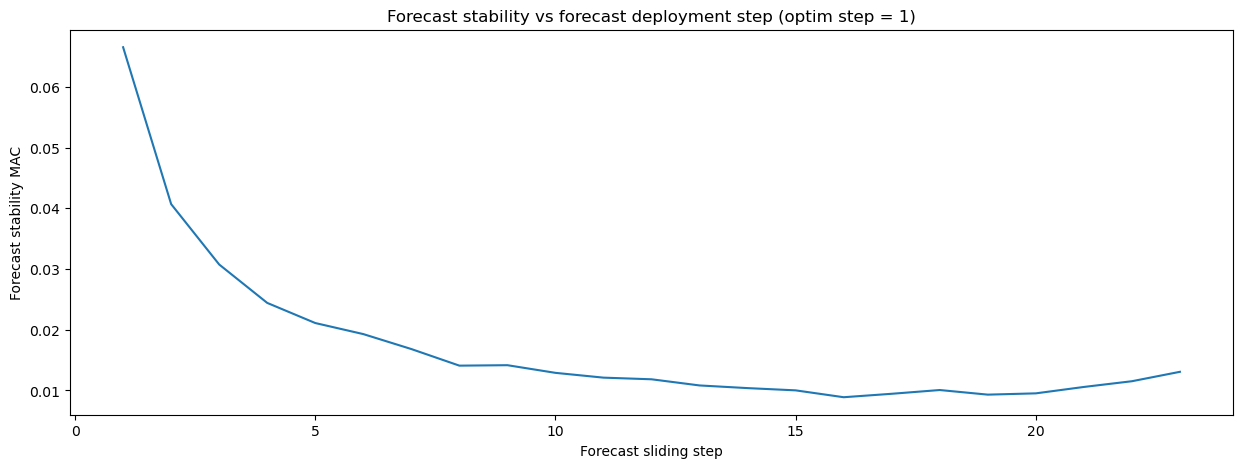

In [8]:
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys()), list(MAC_steps_dict.values()))
ax.set_xlabel('Forecast sliding step')
ax.set_ylabel('Forecast stability MAC')
ax.set_title(f'Forecast stability vs forecast deployment step (optim step = {1})')
plt.show()

In [9]:
phase_num = 3
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 24):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    for b_num in range(1, 5):
        tog_forecast_temp = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
        tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
        tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        #sMAPC_v = np.zeros(len(tog_forecast_temp)-1)
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        prev_indices, current_indices = generate_lists(1,24)
        for i in range(len(tog_forecast_temp)-1):
            #print(prev_indices, current_indices)
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            #sMAPC_v[i] = sMAPC(tog_forecast_current, tog_forecast_previous)
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        #print(f'sMAPC{sMAPC_v.mean()}')
        print(f'MAC{MAC_v.mean()}')
        #sMAPC_steps[step_forecast][b_num] = sMAPC_v.mean()
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    # sMAPC_steps_dict[step] equals to average of sMAPC over all buildings
    #sMAPC_steps_dict[step_forecast] = np.mean(list(sMAPC_steps[step_forecast].values()))
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

MAC0.07592495715342319
MAC0.049246548250728245
MAC0.07333933372709868
MAC0.06662002933650757
MAC0.04906553308225197
MAC0.028989195557145683
MAC0.04373607364017053
MAC0.04096101963125611
MAC0.03754206765816873
MAC0.02079890203966846
MAC0.030904733129608526
MAC0.03110954394550678
MAC0.02941903235637801
MAC0.016817565118824453
MAC0.024935501473483477
MAC0.024145884285603672
MAC0.027275115047426034
MAC0.01420140367454605
MAC0.0207394440131886
MAC0.02126687693784689
MAC0.025934774804767823
MAC0.012607639002410962
MAC0.01893159508004344
MAC0.019906933015532206
MAC0.023262992761132542
MAC0.011816663987420569
MAC0.017435428432313844
MAC0.018068579387993753
MAC0.019211462651405678
MAC0.011314969094514273
MAC0.016867434918058595
MAC0.016364959052622835
MAC0.02139727141299362
MAC0.010955651972191472
MAC0.01585517529093088
MAC0.01725435610672029
MAC0.02072967260476827
MAC0.01076136355084382
MAC0.015823464378141812
MAC0.016838243233731315
MAC0.020557739763040095
MAC0.01082688869701429
MAC0.01587192

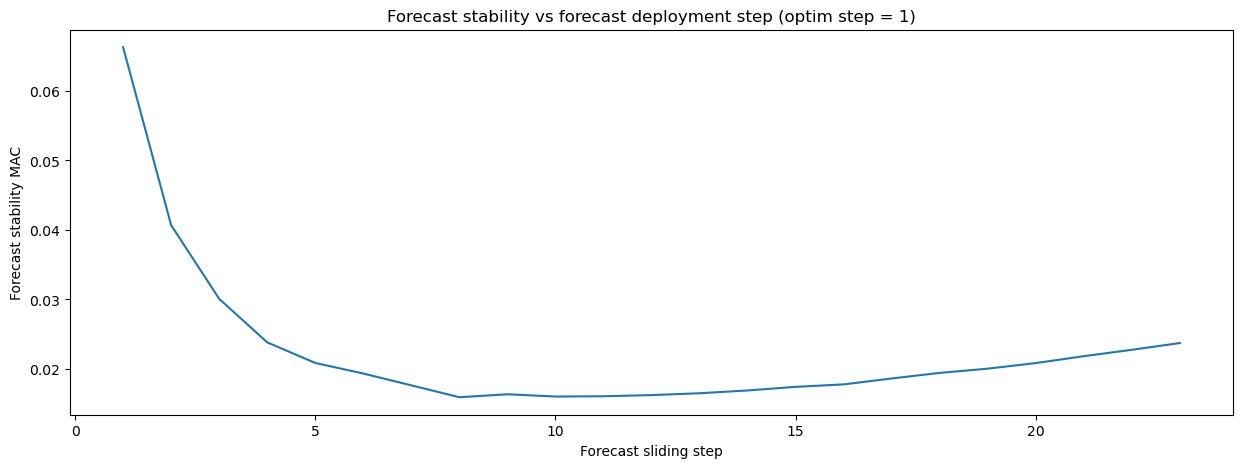

In [10]:
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys()), list(MAC_steps_dict.values()))
ax.set_xlabel('Forecast sliding step')
ax.set_ylabel('Forecast stability MAC')
ax.set_title(f'Forecast stability vs forecast deployment step (optim step = {1})')
plt.show()

In [11]:
phase_num = 3
MAC_steps = {}
MAC_steps_dict = {}
for step_forecast in range(2, 25):
    MAC_steps[step_forecast] = {}
    for b_num in range(1, 5):
        tog_forecast_temp = pd.read_csv(f'debug_logs/pow_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
        tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
        tog_forecast_temp.drop(columns=['building'], inplace=True)
        prev_indices, current_indices = generate_lists(1,24)
        print(prev_indices, current_indices)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        for i in range(len(tog_forecast_temp)-1):
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        #print(f'sMAPC{sMAPC_v.mean()}
        print(f'MAC{MAC_v.mean()}')
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.1411727713697274
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.2474354697680087
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.2609532498231714
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.15806066990280315
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.13811384422736042
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
MAC0.24374329595718697
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 

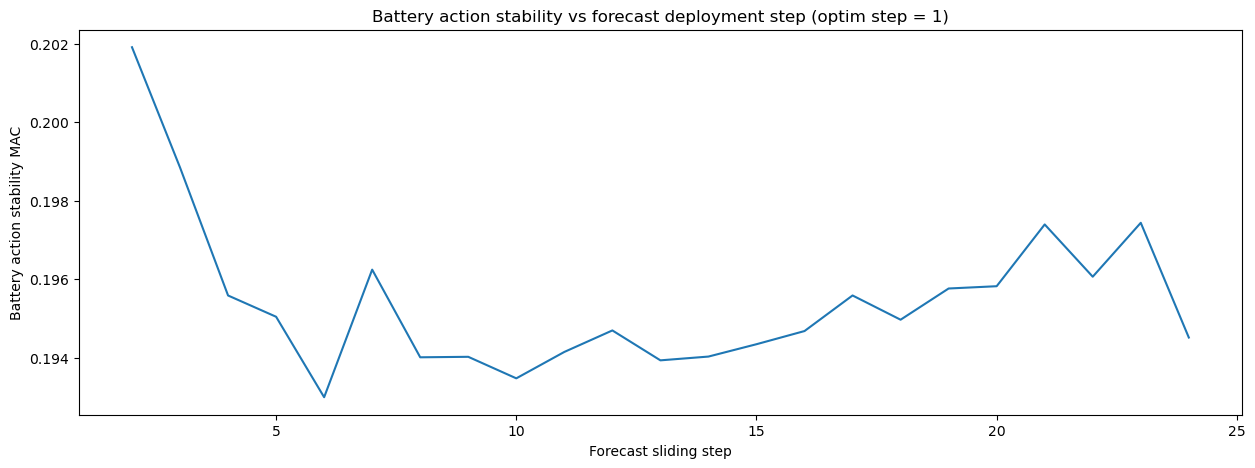

In [12]:
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys()), list(MAC_steps_dict.values()))
ax.set_xlabel('Forecast sliding step')
ax.set_ylabel('Battery action stability MAC')
ax.set_title(f'Battery action stability vs forecast deployment step (optim step = {1})')
plt.show()

In [41]:
phase_num = 3
MAC_steps = {}
MAC_steps_dict = {}
for step_forecast in range(1, 24):
    MAC_steps[step_forecast] = {}
    for b_num in range(1, 5):
        tog_forecast_temp = pd.read_csv(f'debug_logs/pow_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
        tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
        tog_forecast_temp.drop(columns=['building'], inplace=True)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        for i in range(len(tog_forecast_temp)-1):
            step_shift = i % 1
            #print(step_shift)
            prev_indices, current_indices = generate_lists(step_shift,24)
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        #print(f'sMAPC{sMAPC_v.mean()}
        print(f'MAC{MAC_v.mean()}')
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

MAC0.14895332780783654
MAC0.2589439118070358
MAC0.2710270602903076
MAC0.15676359044383248
MAC0.14212587044642158
MAC0.2514072259847772
MAC0.2580791999601525
MAC0.15597504453321726
MAC0.1391759166157114
MAC0.24803801548479495
MAC0.25484808498692646
MAC0.15409963265440724
MAC0.13619413113332957
MAC0.24463030071144035
MAC0.2507218875755848
MAC0.15309302763942073
MAC0.13533658659568248
MAC0.24395781166005134
MAC0.2497761757754488
MAC0.15315784866777774
MAC0.1328683070685823
MAC0.2432257933163049
MAC0.24702521297666907
MAC0.15126078234288248
MAC0.13741946467348684
MAC0.24555223056726574
MAC0.25013834818347186
MAC0.1540757055915269
MAC0.13417337878697363
MAC0.2438979123663123
MAC0.24813948032911473
MAC0.152527689061679
MAC0.1358715781277465
MAC0.24066373365020644
MAC0.24871834116255506
MAC0.15329726796221832
MAC0.13564568976668748
MAC0.24083101720922434
MAC0.24831812496632114
MAC0.15199248186966594
MAC0.13775760041105428
MAC0.24209758520043898
MAC0.24667741057219897
MAC0.1524842886489273
MAC

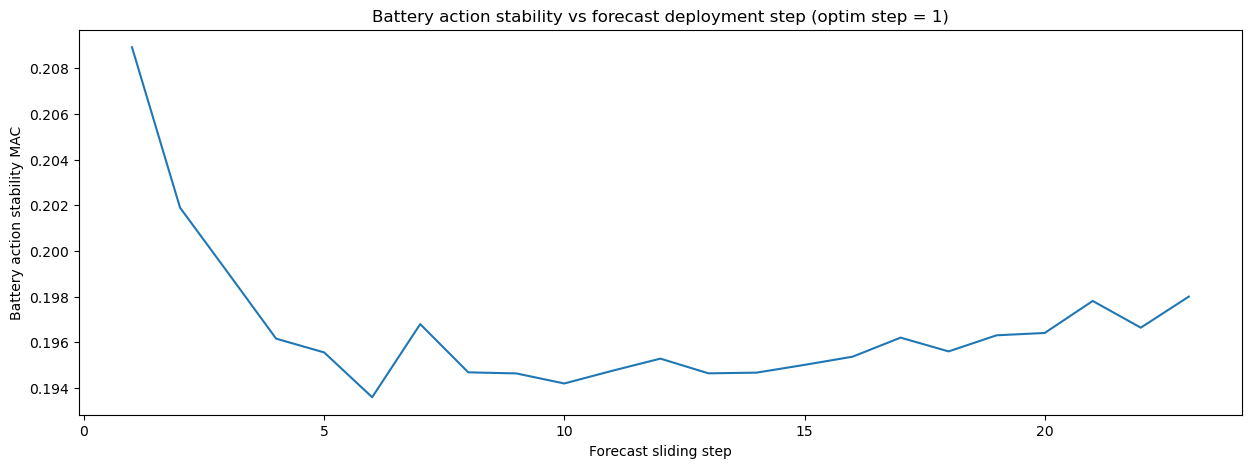

In [42]:
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys()), list(MAC_steps_dict.values()))
ax.set_xlabel('Forecast sliding step')
ax.set_ylabel('Battery action stability MAC')
ax.set_title(f'Battery action stability vs forecast deployment step (optim step = {1})')
plt.show()

In [6]:
def repeat_numbers(seq_list, repeat_count):
    repeated_list = []
    for num in seq_list:
        repeated_list.extend([num] * repeat_count)
    return repeated_list

In [38]:
step_optim = 4
step_forecast = 5
tog_forecast_temp = pd.read_csv(f'debug_logs/pow_gurobi_phase_{phase_num}_step_leap_{step_optim}_forecast_step_{step_forecast}_modifed.csv', index_col='time_step')
tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
tog_forecast_temp.drop(columns=['building'], inplace=True)
tog_forecast_temp

+0h       +1h       +2h       +3h       +4h       +5h  \
time_step                                                               
0          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3          0.000000  0.000000  0.000000  0.000000  0.000000  0.504853   
4          0.000000  0.000000  0.000000  0.000000  0.504853  0.887979   
...             ...       ...       ...       ...       ...       ...   
8752       0.000000 -2.175574  0.000000 -1.500392 -0.540251 -1.145050   
8753      -2.175574  0.000000 -1.500392 -0.540251 -1.145050  0.000000   
8754       0.000000 -1.500392 -0.540251 -1.145050  0.000000  0.000000   
8755      -1.500392 -0.540251 -1.145050  0.000000  0.000000 -0.151425   
8756       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                +6h       +7h       +8h       +9h  ...      +14h      +15h  \
time_step                                          ...                       
0          0.000000  0.000000  0.504853  0.887979  ...  0.674543 -0.260035   
1          0.000000  0.504853  0.887979  1.162862  ... -0.260035 -0.671301   
2          0.504853  0.887979  1.162862  1.286299  ... -0.671301 -1.186248   
3          0.887979  1.162862  1.286299  1.393595  ... -1.186248 -1.439446   
4          1.162862  1.286299  1.393595  1.114808  ... -1.439446 -1.337567   
...             ...       ...       ...       ...  ...       ...       ...   
8752       0.000000  0.000000 -0.151425  0.000000  ...  0.000000  0.029912   
8753       0.000000 -0.151425  0.000000  0.000000  ...  0.029912 -0.024827   
8754      -0.151425  0.000000  0.000000  0.000000  ... -0.024827  0.350396   
8755       0.000000  0.000000  0.000000  0.000000  ...  0.350396  0.244213   
8756       0.000000  1.381007  0.000000  0.057808  ...  0.244213  2.652844   

               +16h      +17h      +18h      +19h      +20h      +21h  \
time_step                                                               
0         -0.671301 -1.186248 -1.439446 -1.337567 -0.918601  0.000000   
1         -1.186248 -1.439446 -1.337567 -0.918601  0.000000  0.000000   
2         -1.439446 -1.337567 -0.918601  0.000000  0.000000 -0.017460   
3         -1.337567 -0.918601  0.000000  0.000000 -0.017460       NaN   
4         -0.936060  0.000000  0.000000  0.000000  0.000000  0.000000   
...             ...       ...       ...       ...       ...       ...   
8752      -0.024827  0.350396  0.244213  0.313193  0.000000  0.000000   
8753       0.350396  0.244213  0.313193  0.000000  0.000000  0.000000   
8754       0.244213  0.313193  0.000000  0.000000  0.000000 -0.753470   
8755       0.313193  0.000000  0.000000  0.000000 -0.753470       NaN   
8756       0.000000  0.000000  0.000000 -1.015017 -1.333128 -1.982119   

              +22h      +23h  
time_step                     
0          0.00000 -0.017460  
1         -0.01746       NaN  
2              NaN       NaN  
3              NaN       NaN  
4          0.00000  0.000000  
...            ...       ...  
8752       0.00000 -0.753470  
8753      -0.75347       NaN  
8754           NaN       NaN  
8755           NaN       NaN  
8756       0.00000 -1.500392  

[8757 rows x 24 columns]

In [37]:
step_optim = 4
step_forecast = 5
tog_forecast_temp = pd.read_csv(f'debug_logs/pow_gurobi_phase_{phase_num}_step_leap_{step_optim}_forecast_step_{step_forecast}_modifed.csv', index_col='time_step')
tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
tog_forecast_temp.drop(columns=['building'], inplace=True)
        # impute the row above for missing indexes
tog_forecast_array = tog_forecast_temp.values
for i in range(len(tog_forecast_temp)-1):
    step_shift = i % step_forecast
    #print(step_shift)
    prev_indices, current_indices = generate_lists(step_shift,24)
    print(prev_indices, current_indices)
    print(tog_forecast_array[i, prev_indices],tog_forecast_array[i+1, current_indices])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[ 0.          0.          0.          0.          0.          0.
  0.          0.50485277  0.88797866  1.16286215  1.28629907  1.39359505
  1.11480823  0.67454261 -0.26003453 -0.67130061 -1.18624777 -1.43944592
 -1.33756671 -0.91860079  0.          0.         -0.01745967] [ 0.          0.          0.          0.          0.          0.
  0.          0.50485277  0.88797866  1.16286215  1.28629907  1.39359505
  1.11480823  0.67454261 -0.26003453 -0.67130061 -1.18624777 -1.43944592
 -1.33756671 -0.91860079  0.          0.         -0.01745967]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 0.          0.          0.          0.          0.          0.
  0.50485277  0.88797866  1.16286215  1.28629907  1.39359505  1.11480823
  0.67454261 -0.26003453 -0.67130061 -

In [39]:
phase_num = 3
sMAPC_steps = {}
MAC_steps_dict = {}
for step_optim in range(2, 24):
    MAC_steps_dict[step_optim] = {}
    MAC_steps = {}
    for step_forecast in range(step_optim, 24):
        MAC_steps[step_forecast] = {}
        for b_num in range(1, 5):
            MAC_steps[step_forecast] = {}
            tog_forecast_temp = pd.read_csv(f'debug_logs/pow_gurobi_phase_{phase_num}_step_leap_{step_optim}_forecast_step_{step_forecast}_modifed.csv', index_col='time_step')
            tog_forecast_temp = tog_forecast_temp[tog_forecast_temp['building'] == b_num]
            tog_forecast_temp.drop(columns=['building'], inplace=True)
            # impute the row above for missing indexes
            tog_forecast_array = tog_forecast_temp.values
            MAC_v = np.zeros(len(tog_forecast_temp)-1)
            for i in range(len(tog_forecast_temp)-1):
                step_shift = i % step_optim
                #print(step_shift)
                prev_indices, current_indices = generate_lists(step_shift,24)
                tog_forecast_previous = tog_forecast_array[i, prev_indices]
                tog_forecast_current = tog_forecast_array[i+1, current_indices]
                MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
            print(f'MAC{MAC_v.mean()}')
            MAC_steps[step_forecast][b_num] = MAC_v.mean()
        # sMAPC_steps_dict[step] equals to average of sMAPC over all buildings
        MAC_steps_dict[step_optim][step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

MAC0.08501500883962539
MAC0.13655495264681877
MAC0.14064023986297258
MAC0.08736482189821318
MAC0.08010944851122972
MAC0.13258347433889092
MAC0.13419732301995166
MAC0.08369918217316491
MAC0.07776359103701369
MAC0.132105352421899
MAC0.13379727094797908
MAC0.08450077092908759
MAC0.07679444628882498
MAC0.12902309037688886
MAC0.13165014776328673
MAC0.08333974030264361
MAC0.07564079318190303
MAC0.13040590400617774
MAC0.13218654322354192
MAC0.08226341650414129
MAC0.07634942135783726
MAC0.1294926047048336
MAC0.1310799139671663
MAC0.08512232496085496
MAC0.07334579089884889
MAC0.12942365880000037
MAC0.13032321693535234
MAC0.08332343939801873
MAC0.07546485439407292
MAC0.12857340580996052
MAC0.12834278962981732
MAC0.0827656245029306
MAC0.07473536530829487
MAC0.1286222332242382
MAC0.1287742394572708
MAC0.08193109177947935
MAC0.07481604084936158
MAC0.12842691592794747
MAC0.12902858747251872
MAC0.08277983215906083
MAC0.07462570563069773
MAC0.12898055949501627
MAC0.12843560793063621
MAC0.0834863541865

In [40]:
# ts_dict to dataframe
df = pd.DataFrame.from_dict(MAC_steps_dict)
# save to csv
df.to_csv("stability_battery_study_24_phase_3.csv")